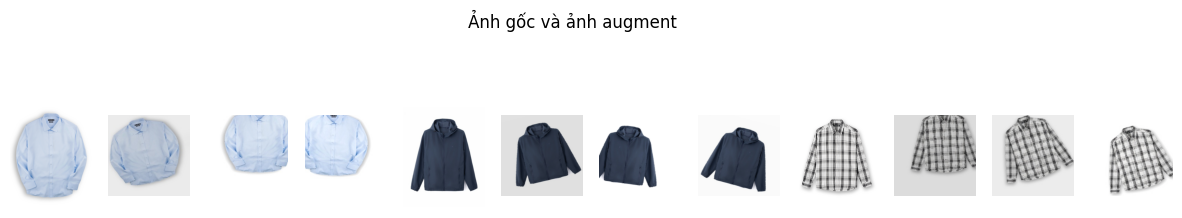

In [2]:
import os
import requests
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
API_URL = "http://localhost:8080/api/v1/public/images"

def augment_image(img_path, n_aug=3):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    aug_iter = datagen.flow(img_array, batch_size=1)
    aug_imgs = []
    for _ in range(n_aug):
        aug_img = next(aug_iter)[0].astype('uint8')
        aug_imgs.append(aug_img)
    return aug_imgs
def download_and_augment_images(api_url, n_aug=3):
    response = requests.get(api_url)
    data = response.json()
    if response.status_code != 200 or "data" not in data:
        print("❌ Không thể lấy danh sách ảnh từ API!")
        return []
    images = data["data"]
    os.makedirs("temp/original", exist_ok=True)
    os.makedirs("temp/augmented", exist_ok=True)
    image_paths = []
    for img_info in images:
        img_url = img_info["path"]
        filename = os.path.basename(img_url)
        img_path = f"temp/original/{filename}"
        try:
            img_response = requests.get(img_url, stream=True)
            if img_response.status_code == 200:
                with open(img_path, "wb") as f:
                    f.write(img_response.content)
                image_paths.append(img_path)
                # Sinh nhiều ảnh augment
                aug_imgs = augment_image(img_path, n_aug=n_aug)
                for idx, aug_img in enumerate(aug_imgs):
                    aug_img_path = f"temp/augmented/aug{idx+1}_{filename}"
                    cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
                    image_paths.append(aug_img_path)
            else:
                print(f"⚠️ Không thể đọc ảnh từ {img_url}")
        except Exception as e:
            print(f"❌ Lỗi khi xử lý ảnh {img_url}: {e}")
    return image_paths

def visualize_original_and_augmented(image_paths, num_show=12):
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(image_paths[:num_show]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_show, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle("Ảnh gốc và ảnh augment")
    plt.show()

if __name__ == "__main__":
    n_augmented = 3  # Số lượng ảnh augment mỗi ảnh gốc
    image_paths = download_and_augment_images(API_URL, n_aug=n_augmented)
    if image_paths:
        visualize_original_and_augmented(image_paths, num_show=12)
    else:
        print("Không có ảnh nào để hiển thị.")

2. Trích xuất đặc trưng từ ảnh

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from numpy.linalg import norm

def load_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        GlobalMaxPooling2D()
    ])
    return model

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

model = load_resnet_model()
features_dict = {}
for img_path in image_paths:
    features_dict[os.path.basename(img_path)] = extract_features(img_path, model)

print("Số lượng vector đặc trưng đã trích xuất:", len(features_dict))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


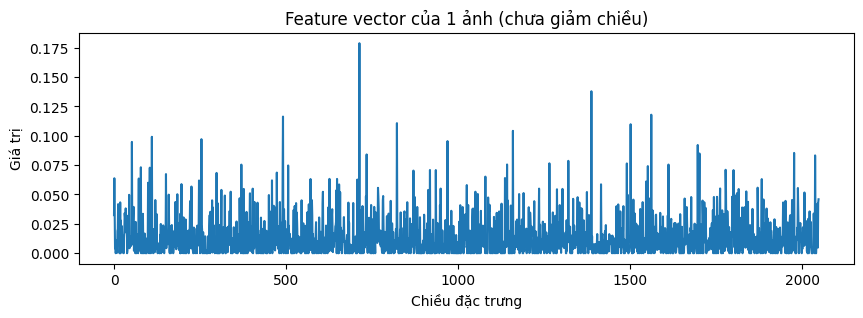

In [4]:
# Giả sử img_path là đường dẫn ảnh bạn muốn xem đặc trưng
single_feature = extract_features(img_path, model)
plt.figure(figsize=(10, 3))
plt.plot(single_feature)
plt.title("Feature vector của 1 ảnh (chưa giảm chiều)")
plt.xlabel("Chiều đặc trưng")
plt.ylabel("Giá trị")
plt.show()

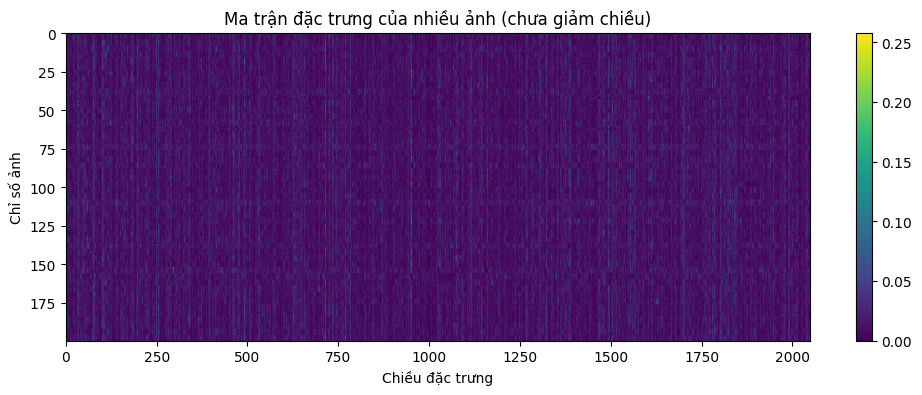

In [5]:
feature_list = np.array(list(features_dict.values()))
plt.figure(figsize=(12, 4))
plt.imshow(feature_list, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Ma trận đặc trưng của nhiều ảnh (chưa giảm chiều)")
plt.xlabel("Chiều đặc trưng")
plt.ylabel("Chỉ số ảnh")
plt.show()

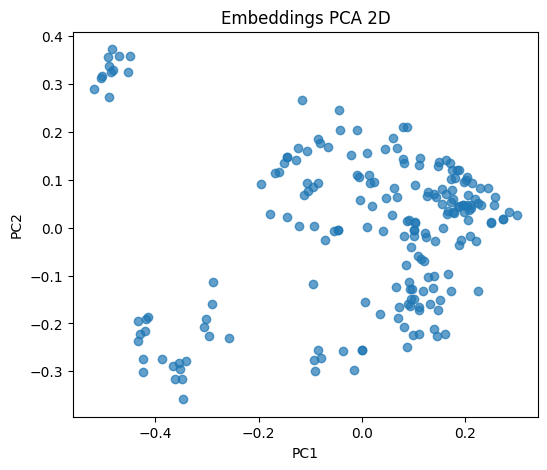

In [6]:
from sklearn.decomposition import PCA

feature_list = np.array(list(features_dict.values()))
if len(feature_list) > 2:
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(feature_list)
    plt.figure(figsize=(6, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    plt.title("Embeddings PCA 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
else:
    print("Không đủ dữ liệu để trực quan hóa PCA.")

3. Trực quan hóa đặc trưng (PCA 2D)

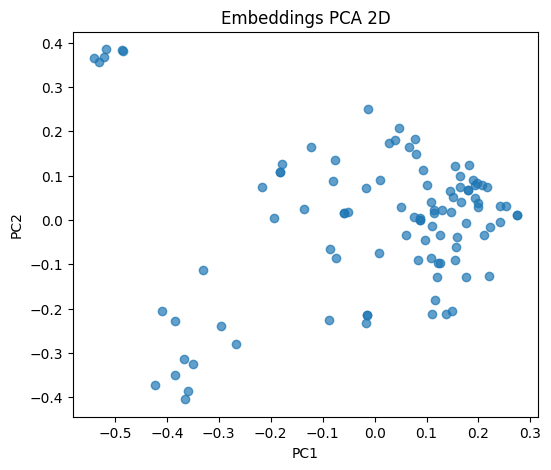

In [5]:
from sklearn.decomposition import PCA

def visualize_embeddings(features_dict):
    feature_list = np.array(list(features_dict.values()))
    if len(feature_list) > 2:
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(feature_list)
        plt.figure(figsize=(6, 5))
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
        plt.title("Embeddings PCA 2D")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()
    else:
        print("Không đủ dữ liệu để trực quan hóa PCA.")

visualize_embeddings(features_dict)

4. Lưu database đặc trưng

In [ ]:
import pickle
from sklearn.neighbors import NearestNeighbors

def save_database(features_dict, save_dir="app/resnet/"):
    os.makedirs(save_dir, exist_ok=True)
    filenames = np.array(list(features_dict.keys()))
    feature_list = np.array(list(features_dict.values()))
    # PCA giảm chiều nếu cần
    if len(feature_list) > 5:
        n_components = min(512, len(feature_list))
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(feature_list)
        pickle.dump(pca, open(os.path.join(save_dir, "pca.pkl"), "wb"))
        print(f"✅ Áp dụng PCA với {n_components} thành phần!")
    else:
        reduced_features = feature_list
    pickle.dump(features_dict, open(os.path.join(save_dir, "features.pkl"), "wb"))
    pickle.dump(filenames, open(os.path.join(save_dir, "filenames.pkl"), "wb"))
    nn_model = NearestNeighbors(n_neighbors=4, metric="cosine")
    nn_model.fit(feature_list)
    pickle.dump(nn_model, open(os.path.join(save_dir, "nn_model.pkl"), "wb"))
    print("✅ Đã lưu embeddings, PCA & NearestNeighbors model thành công!")

save_database(features_dict)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def show_cosine_similarity(query_img_path, features_dict, model, top_k=5):
    # Trích xuất đặc trưng cho ảnh truy vấn
    query_feature = extract_features(query_img_path, model).reshape(1, -1)
    feature_list = np.array(list(features_dict.values()))
    filenames = np.array(list(features_dict.keys()))
    # Tính cosine similarity
    similarities = cosine_similarity(query_feature, feature_list)[0]
    # Lấy top_k ảnh giống nhất
    top_idx = similarities.argsort()[::-1][:top_k]
    print("Top", top_k, "ảnh giống nhất với", os.path.basename(query_img_path))
    for i, idx in enumerate(top_idx):
        print(f"{i+1}. {filenames[idx]} - Cosine similarity: {similarities[idx]:.4f}")
    # Hiển thị ảnh truy vấn và các ảnh tương tự
    plt.figure(figsize=(12, 3))
    # Ảnh truy vấn
    img = cv2.imread(query_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, top_k+1, 1)
    plt.imshow(img)
    plt.title("Query")
    plt.axis('off')
    # Ảnh tương tự
    for i, idx in enumerate(top_idx):
        img_sim = cv2.imread(os.path.join("temp/original", filenames[idx])) \
            if not filenames[idx].startswith("aug_") \
            else cv2.imread(os.path.join("temp/augmented", filenames[idx]))
        img_sim = cv2.cvtColor(img_sim, cv2.COLOR_BGR2RGB)
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(img_sim)
        plt.title(f"Sim: {similarities[idx]:.2f}")
        plt.axis('off')
    plt.show()

# Ví dụ sử dụng:
show_cosine_similarity(image_paths[0], features_dict, model, top_k=5)

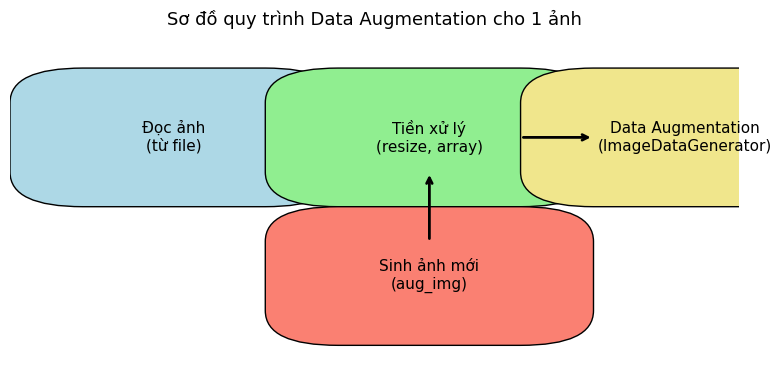

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 4))

# Vẽ các khối
ax.add_patch(patches.FancyBboxPatch((0.1, 0.6), 0.25, 0.2, boxstyle="round,pad=0.1", fc="lightblue"))
ax.text(0.225, 0.7, "Đọc ảnh\n(từ file)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.45, 0.6), 0.25, 0.2, boxstyle="round,pad=0.1", fc="lightgreen"))
ax.text(0.575, 0.7, "Tiền xử lý\n(resize, array)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.8, 0.6), 0.25, 0.2, boxstyle="round,pad=0.1", fc="khaki"))
ax.text(0.925, 0.7, "Data Augmentation\n(ImageDataGenerator)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.45, 0.2), 0.25, 0.2, boxstyle="round,pad=0.1", fc="salmon"))
ax.text(0.575, 0.3, "Sinh ảnh mới\n(aug_img)", ha="center", va="center", fontsize=11)

# Vẽ mũi tên
ax.annotate("", xy=(0.35, 0.7), xytext=(0.1+0.25, 0.7), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.7), xytext=(0.45+0.25, 0.7), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.575, 0.6), xytext=(0.575, 0.4), arrowprops=dict(arrowstyle="->", lw=2))

# Tắt trục
ax.axis('off')
plt.title("Sơ đồ quy trình Data Augmentation cho 1 ảnh", fontsize=13)
plt.tight_layout()
plt.show()

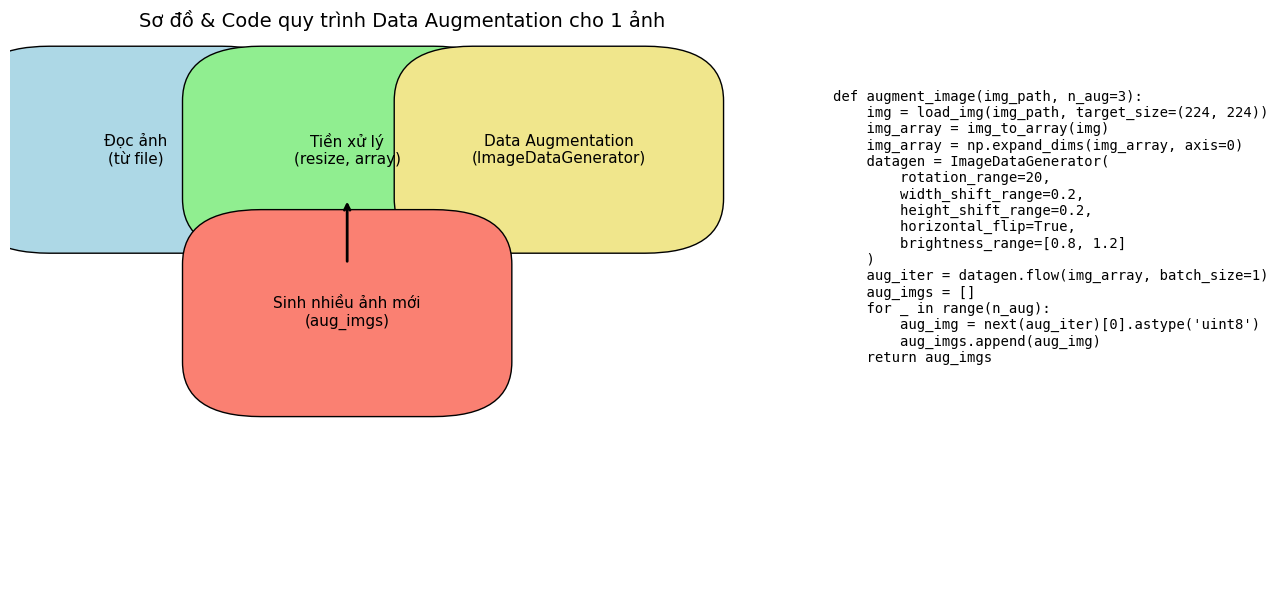

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Đoạn code sẽ hiển thị trên biểu đồ
code = """
def augment_image(img_path, n_aug=3):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    aug_iter = datagen.flow(img_array, batch_size=1)
    aug_imgs = []
    for _ in range(n_aug):
        aug_img = next(aug_iter)[0].astype('uint8')
        aug_imgs.append(aug_img)
    return aug_imgs
"""

fig, ax = plt.subplots(figsize=(13, 6))  # Tăng width để đủ chỗ cho code

# Vẽ các khối quy trình
ax.add_patch(patches.FancyBboxPatch((0.05, 0.7), 0.22, 0.18, boxstyle="round,pad=0.1", fc="lightblue"))
ax.text(0.16, 0.79, "Đọc ảnh\n(từ file)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.32, 0.7), 0.22, 0.18, boxstyle="round,pad=0.1", fc="lightgreen"))
ax.text(0.43, 0.79, "Tiền xử lý\n(resize, array)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.59, 0.7), 0.22, 0.18, boxstyle="round,pad=0.1", fc="khaki"))
ax.text(0.70, 0.79, "Data Augmentation\n(ImageDataGenerator)", ha="center", va="center", fontsize=11)

ax.add_patch(patches.FancyBboxPatch((0.32, 0.4), 0.22, 0.18, boxstyle="round,pad=0.1", fc="salmon"))
ax.text(0.43, 0.49, "Sinh nhiều ảnh mới\n(aug_imgs)", ha="center", va="center", fontsize=11)

# Vẽ mũi tên
ax.annotate("", xy=(0.27, 0.79), xytext=(0.05+0.22, 0.79), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.54, 0.79), xytext=(0.32+0.22, 0.79), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.43, 0.7), xytext=(0.43, 0.58), arrowprops=dict(arrowstyle="->", lw=2))

# Hiển thị code sát ngoài cùng bên phải
plt.text(1.05, 0.95, "", fontsize=12, fontweight='bold', va='top', transform=ax.transAxes)
plt.text(1.05, 0.93, code, fontsize=10, family='monospace', va='top', transform=ax.transAxes)

# Tắt trục
ax.axis('off')
plt.title("Sơ đồ & Code quy trình Data Augmentation cho 1 ảnh", fontsize=14)
plt.tight_layout()
plt.show()